# Etude 1 - Training SVM Classifiers

Train a LinearSVC on a linearly separable dataset. Then train an SVC and a SGDClassifier on the same dataset. See if you can get them to produce roughly the same model.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import datasets
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.svm import SVR

### Loading and Plotting the Iris Dataset

In [ ]:
iris = datasets.load_iris()

In [ ]:
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [ ]:
iris.feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [ ]:
# we will use only petal dimensions
X, y = iris['data'][:, (2,3)], iris['target']

Since we need a linearly separate dataset, let's filter out virginica.

In [ ]:
setosa_or_versicolor = (y == 0) | (y == 1) # filters out virginica 

In [ ]:
X = X[setosa_or_versicolor]
y = y[setosa_or_versicolor]

Let's plot our data.

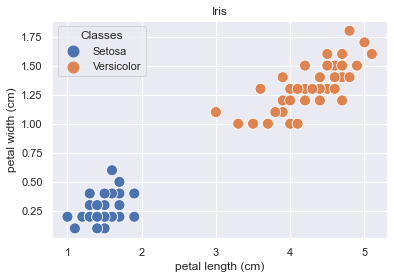

In [ ]:
fig = plt.figure()
ax = plt.axes()

ax = sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y,  size=y, sizes=(120, 120))

leg_handles = ax.get_legend_handles_labels()[0]
ax.legend(leg_handles, ['Setosa', 'Versicolor'], title='Classes')
ax.set_xlabel(iris.feature_names[2])
ax.set_ylabel(iris.feature_names[3])
ax.set_title('Iris');

### Scaling the Data and Preparing Test/Train Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# scaling Xs
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_scaled = scaler.transform(X) # for graphs

Note that we should never run the fit() function on the test data, only on the train.

### Training Classifiers

In [ ]:
linear_svc_clf = LinearSVC()
svc_clf = SVC(kernel='linear')
sgd_clf = SGDClassifier(n_jobs=-1)

In [ ]:
linear_svc_clf.fit(X_train_scaled, y_train)

LinearSVC()

In [ ]:
svc_clf.fit(X_train_scaled, y_train)

SVC(kernel='linear')

In [ ]:
sgd_clf.fit(X_train_scaled, y_train)

SGDClassifier(n_jobs=-1)

In [ ]:
y_pred_linear_svc = linear_svc_clf.predict(X_test_scaled)
y_pred_svc = svc_clf.predict(X_test_scaled)
y_pred_sgd = sgd_clf.predict(X_test_scaled)

Accuracy scores for each classifier.

In [ ]:
accuracy_score(y_test, y_pred_linear_svc)

1.0

In [ ]:
accuracy_score(y_test, y_pred_svc)

1.0

In [ ]:
accuracy_score(y_test, y_pred_sgd)

1.0

The result is obvious.

### Decision Boundaries

This funciton shows how the decision function looks for the LinearSVC classifier. Note that since the initial dataset was standartized, you need to standartize the decision boundary function. See the solution.

In [ ]:
linear_svc_clf.coef_

array([[0.88826351, 0.77467662]])

In [ ]:
linear_svc_clf.intercept_

array([0.32585647])

In [ ]:
for (intercept, coef) in zip(linear_svc_clf.intercept_, linear_svc_clf.coef_):
    s = "y = {0:.3f}".format(intercept)
    for (i, c) in enumerate(coef):
        s += " + {0:.3f} * x{1}".format(c, i)

    print(s)

y = 0.326 + 0.888 * x0 + 0.775 * x1


This function builds a dicision boundary function of the LinearSVC.

In [ ]:
xx = np.linspace(-2, 2)
a = - linear_svc_clf.coef_[0][0] / linear_svc_clf.coef_[0][1]
b = - (linear_svc_clf.intercept_[0]) / linear_svc_clf.coef_[0][1]
yy = a * xx + b

Let's build a graph with the decision boundary (we should not forget to use scaled feature vector). 

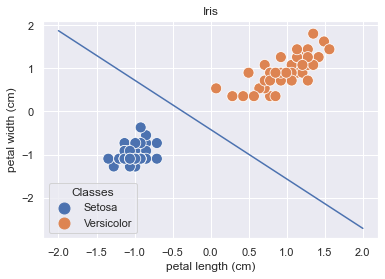

In [ ]:
ax = sns.scatterplot(x=X_scaled[:, 0], y=X_scaled[:, 1], hue=y,  size=y, sizes=(120, 120))
sns.lineplot(x = xx, y = yy)
leg_handles = ax.get_legend_handles_labels()[0]
ax.legend(leg_handles, ['Setosa', 'Versicolor'], title='Classes')
ax.set_xlabel(iris.feature_names[2])
ax.set_ylabel(iris.feature_names[3])
ax.set_title('Iris');

plt.show()

### Extra: The Helper Class for Testing Several Classifiers

Unfortunately, Scikit-Learn does not provide the standard methods of using grid search with various classifiers. To overcome this problem, we will use the following class.

In [ ]:
# http://www.davidsbatista.net/blog/2018/02/23/model_optimization/
class EstimatorSelectionHelper:

    def __init__(self, models, params):
        if not set(models.keys()).issubset(set(params.keys())):
            missing_params = list(set(models.keys()) - set(params.keys()))
            raise ValueError("Some estimators are missing parameters: %s" % missing_params)
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv=5, n_jobs=-1, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print("Running GridSearchCV for %s." % key)
            model = self.models[key]
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, refit=refit,
                              return_train_score=True)
            gs.fit(X,y)
            self.grid_searches[key] = gs    

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                 'estimator': key,
                 'min_score': min(scores),
                 'max_score': max(scores),
                 'mean_score': np.mean(scores),
                 'std_score': np.std(scores),
            }
            return pd.Series({**params,**d})

        rows = []
        for k in self.grid_searches:
            print(k)
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]        
                scores.append(r.reshape(len(params),1))

            all_scores = np.hstack(scores)
            for p, s in zip(params,all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns]

In [ ]:
models = {
    'LinearSVCClassifier': LinearSVC(),
    'SVCClassifier': SVC(kernel='linear'),
    'SGDClassifier': SGDClassifier(n_jobs=-1),
}

params = {
    'LinearSVCClassifier': {},
    'SVCClassifier': {},
    'SGDClassifier': {}
}

In [ ]:
classifiers = EstimatorSelectionHelper(models, params)
classifiers.fit(X_train_scaled, y_train, scoring='f1')

Running GridSearchCV for LinearSVCClassifier.
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Running GridSearchCV for SVCClassifier.
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Running GridSearchCV for SGDClassifier.
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


In [ ]:
classifiers.score_summary(sort_by='max_score')

LinearSVCClassifier
SVCClassifier
SGDClassifier


,estimator,min_score,mean_score,max_score,std_score
0,LinearSVCClassifier,1,1,1,0
1,SVCClassifier,1,1,1,0
2,SGDClassifier,1,1,1,0


# Etude 2 - Training an SVM Classifier

Train an SVM classifier on the MNIST dataset. Since SVM classifiers are binary classifiers, we will need to use one-versus-all to classify all 10 digits. We may also want to tune the hyperparameters using small validation sets to speed up the process. What accuracy can we reach?

In [ ]:
try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1, cache=True)
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')

X = mnist["data"]
y = mnist["target"]

X_train = X[:60000]
y_train = y[:60000]
X_test = X[60000:]
y_test = y[60000:]

Now we shuffle the training data.

In [ ]:
idx_shuffle = np.random.permutation(len(X_train))

In [ ]:
X_train = X_train[idx_shuffle]
y_train = y_train[idx_shuffle]

Let's standartize data: 

In [ ]:
# scaling Xs
scaler_mnist = StandardScaler()
X_train_scaled = scaler_mnist.fit_transform(X_train)
X_test_scaled = scaler_mnist.transform(X_test)

### Trying the Linear SVC Classifier

In [ ]:
lin_svc_clf = LinearSVC(dual=False)

In [ ]:
lin_svc_clf.fit(X_train_scaled, y_train)

C:\Users\CS\Anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(dual=False)

Let's see how good the model is.

In [ ]:
y_train_pred = lin_svc_clf.predict(X_test_scaled)

In [ ]:
accuracy_score(y_train_pred, y_test)

0.9157

Now let's look at the confusion matrix.

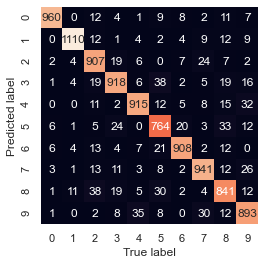

In [ ]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test, y_train_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('True label')
plt.ylabel('Predicted label');

In [ ]:
print(classification_report(y_test, y_train_pred))

              precision    recall  f1-score   support

           0       0.95      0.98      0.96       980
           1       0.95      0.98      0.97      1135
           2       0.93      0.88      0.90      1032
           3       0.89      0.91      0.90      1010
           4       0.92      0.93      0.92       982
           5       0.88      0.86      0.87       892
           6       0.93      0.95      0.94       958
           7       0.92      0.92      0.92      1028
           8       0.87      0.86      0.87       974
           9       0.90      0.89      0.89      1009

    accuracy                           0.92     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.92      0.92      0.92     10000



### Trying the SVC Classifier

In [ ]:
svc_clf_mn = SVC(cache_size=500)

In [ ]:
svc_clf_mn.fit(X_train_scaled, y_train)

SVC(cache_size=500)

In [ ]:
y_train_pred = svc_clf_mn.predict(X_test_scaled)

In [ ]:
accuracy_score(y_train_pred, y_test)

0.966

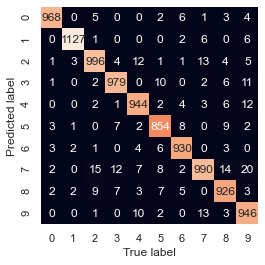

In [ ]:
mat = confusion_matrix(y_test, y_train_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('True label')
plt.ylabel('Predicted label');

In [ ]:
print(classification_report(y_test, y_train_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.96      0.97      0.96      1032
           3       0.97      0.97      0.97      1010
           4       0.97      0.96      0.97       982
           5       0.96      0.96      0.96       892
           6       0.98      0.97      0.98       958
           7       0.93      0.96      0.94      1028
           8       0.96      0.95      0.96       974
           9       0.97      0.94      0.95      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



### Applying the RandomizedSearchCV to the Validation Set

Looks like the SVC classifier produces better results. To speed up the process, let's use RandomizedSearchCV on the validation set to find the optimal hyperparameters.

In [ ]:
X_train_validation = X_train_scaled[:1000]
y_train_validation = y_train[:1000]

Let's check the default value of the 'gamma' parameter. We will use this value as a reference in the grid search.

In [ ]:
1 / (X_train_validation.shape[1] * X_train_validation.var()) # var = 1, since we standardized the data

0.001442159506200535

Now we create a pool of parameters for the RanmodmizedGridSearchCV.

In [ ]:
from scipy.stats import reciprocal, uniform

ransearch_params = {
    'kernel': ['rbf', 'poly'],
    'degree': [3, 5],
    'gamma': reciprocal(0.0001, 0.15),
    'C': uniform(1, 10)
}

In [ ]:
n_iter_search = 800
ransearch = RandomizedSearchCV(svc_clf_mn, ransearch_params, n_iter=n_iter_search, cv=3, n_jobs=-1, verbose=1)

In [ ]:
ransearch.fit(X_train_validation, y_train_validation)

Fitting 3 folds for each of 800 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   53.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed: 11.9min finished


RandomizedSearchCV(cv=3, estimator=SVC(cache_size=500), n_iter=800, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000213C2ABF888>,
                                        'degree': [3, 5],
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000213C2ABF788>,
                                        'kernel': ['rbf', 'poly']},
                   verbose=1)

In [ ]:
ransearch.best_params_

{'C': 7.847937556152125,
 'degree': 3,
 'gamma': 0.0001955157012027784,
 'kernel': 'rbf'}

In [ ]:
ransearch.best_estimator_.fit(X_train_scaled, y_train)

SVC(C=7.847937556152125, cache_size=500, gamma=0.0001955157012027784)

In [ ]:
y_pred = ransearch.best_estimator_.predict(X_test_scaled)

In [ ]:
accuracy_score(y_test, y_pred)

0.9594

We obtained a slightly lower accuracy, but that's because we used the validation set for performance reasons.

# Etude 3 - Training an SVM Regressor

Let's train an SVM regressor on the California housing dataset.

In [ ]:
from sklearn.datasets import fetch_california_housing

housing_bunch = fetch_california_housing()

In [ ]:
housing_bunch.feature_names

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

Let's use the Pandas dataframes.

In [ ]:
housing = pd.DataFrame(data = np.c_[housing_bunch['data'], housing_bunch['target']], columns = [housing_bunch.feature_names + ['Target']])

In [ ]:
housing.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [ ]:
housing.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Target
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


Verifying whether there are any NaNs in the dataset.

In [ ]:
housing.isna().any()

MedInc        False
HouseAge      False
AveRooms      False
AveBedrms     False
Population    False
AveOccup      False
Latitude      False
Longitude     False
Target        False
dtype: bool

Splitting the data into the test and train dataset.

In [ ]:
test, train = train_test_split(housing, train_size=0.2)

Preparing data for the regressor.

In [ ]:
train_labels = train.drop(['Target'], axis=1)
train_target = train[['Target']]

C:\Users\CS\Anaconda3\lib\site-packages\pandas\core\generic.py:3878: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [ ]:
test_labels = test.drop(['Target'], axis=1)
test_target = test[['Target']].copy()

Scaling data.

In [ ]:
# scaling Xs
scaler = StandardScaler()
train_labels_scaled = scaler.fit_transform(train_labels)
test_labels_scaled = scaler.transform(test_labels)

Now let's run the regressor.

In [ ]:
svm_reg = SVR()

In [ ]:
svm_reg.fit(train_labels_scaled, train_target.values.ravel())

SVR()

In [ ]:
y_pred = svm_reg.predict(test_labels_scaled)

Estimating RMSE.

In [ ]:
lin_mse = mean_squared_error(test_target, y_pred)

In [ ]:
np.sqrt(lin_mse)

0.5852266338221073

Now let's use RandomizedSearchCV to reduce the error. First, let's deterimne which gamma value is used by default.

In [ ]:
1 / (train_labels_scaled.shape[0] * train_labels_scaled.var()) # since we standardized data, the variance is 1

6.056201550387597e-05

Let's take into account this value when specifying the distribution for the 'gamma' parameter. 

In [ ]:
from scipy.stats import reciprocal, uniform

rsearch_params = {
    'kernel': ['rbf', 'poly'],
    'gamma': reciprocal(0.000005, 0.007),
    'C': uniform(1, 10)
}

In [ ]:
n_iter_search = 20
rsearch = RandomizedSearchCV(svm_reg, rsearch_params, n_iter=n_iter_search, cv=3, n_jobs=-1, verbose=1)

In [ ]:
rsearch.fit(train_labels_scaled, train_target)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  2.4min finished
C:\Users\CS\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


RandomizedSearchCV(cv=3, estimator=SVR(), n_iter=20, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000213C2C64708>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000213C2C642C8>,
                                        'kernel': ['rbf', 'poly']},
                   verbose=1)

In [ ]:
rsearch.best_params_

{'C': 4.92489480176903, 'gamma': 0.002621502257298209, 'kernel': 'rbf'}

In [ ]:
y_pred = rsearch.best_estimator_.predict(test_labels_scaled)

Estimating the RMSE.

In [ ]:
lin_mse = mean_squared_error(test_target, y_pred)

In [ ]:
np.sqrt(lin_mse)

0.7074250355278185

Somewhat surprisingly, we achieved a higher MSE with randomized search. The main reason for this is that to save time we did not perfrom the sufficient amount of iterations.